In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# paths
base_path = "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split"

# image size and batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Image normalization and augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_data = train_gen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_test_gen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = val_test_gen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep test order fixed
)


Found 2800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# summary
model.summary()


/tmp/ipython-input-205597502.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#paths
base_path = '/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')
model_save_path = '/content/drive/MyDrive/Capstone2025_DeepfakeDetection/mobilenetv2_v3.keras'

# parameters
input_shape = (224, 224, 3)
batch_size = 32
epochs = 15
learning_rate = 1e-4

# data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=input_shape[:2], batch_size=batch_size, class_mode='binary')
val_data = val_test_gen.flow_from_directory(val_path, target_size=input_shape[:2], batch_size=batch_size, class_mode='binary')
test_data = val_test_gen.flow_from_directory(test_path, target_size=input_shape[:2], batch_size=batch_size, class_mode='binary', shuffle=False)

# defining the modle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# compile the model
model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')
]

# train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks
)

Found 2800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


/tmp/ipython-input-2931760815.py:39: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 625s 7s/step - accuracy: 0.5103 - loss: 0.8104 - val_accuracy: 0.4833 - val_loss: 0.7137
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5116 - loss: 0.7401 - val_accuracy: 0.4933 - val_loss: 0.7003
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.5119 - loss: 0.7212 - val_accuracy: 0.5067 - val_loss: 0.6960
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5239 - loss: 0.7046 - val_accuracy: 0.5167 - val_loss: 0.6935
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.5301 - loss: 0.7026 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5257 - loss: 0.6998 - val_accuracy: 0.5350 - val_loss: 0.6908
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.5230 - loss: 0.6954 - val_accuracy: 0.5333 - val_loss: 0.6897
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.5353 - loss: 0.6897 - val_accuracy: 0.5300 - v

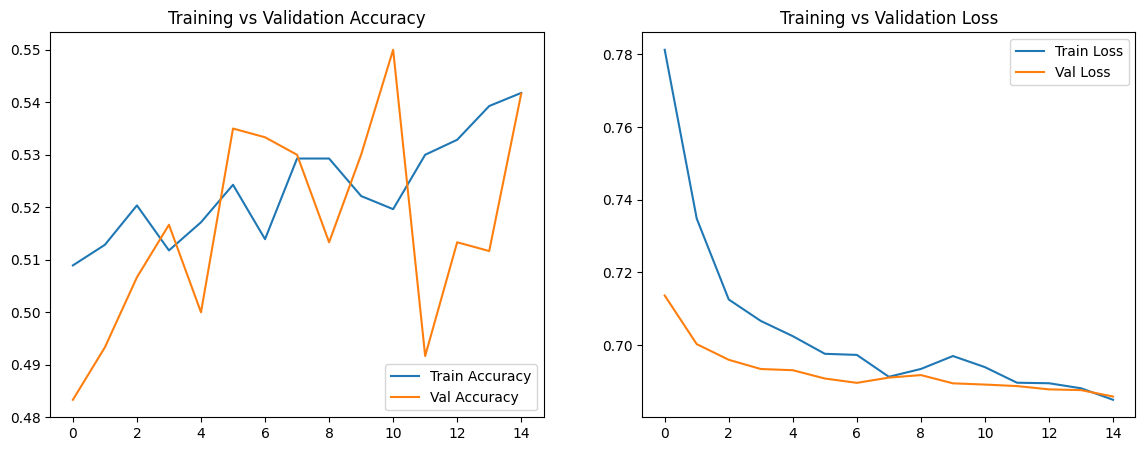

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')

    plt.show()

plot_training_history(history)


In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Final Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.5529 - loss: 0.6886
Final Test Accuracy: 0.5217 | Loss: 0.6893


In [ ]:
import os
import random


test_dir = "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test"

# Gets 3 random real and 3 random fake frame paths
real_test_images = random.sample(
    [os.path.join(test_dir, "real", img) for img in os.listdir(os.path.join(test_dir, "real"))],
    3
)

fake_test_images = random.sample(
    [os.path.join(test_dir, "fake", img) for img in os.listdir(os.path.join(test_dir, "fake"))],
    3
)

selected_images = real_test_images + fake_test_images
for img in selected_images:
    print(img)


/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/real/real089_005.jpg
/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/real/real041_019.jpg
/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/real/real047_002.jpg
/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/fake/fake051_010.jpg
/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/fake/fake054_015.jpg
/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/fake/fake089_008.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_159']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


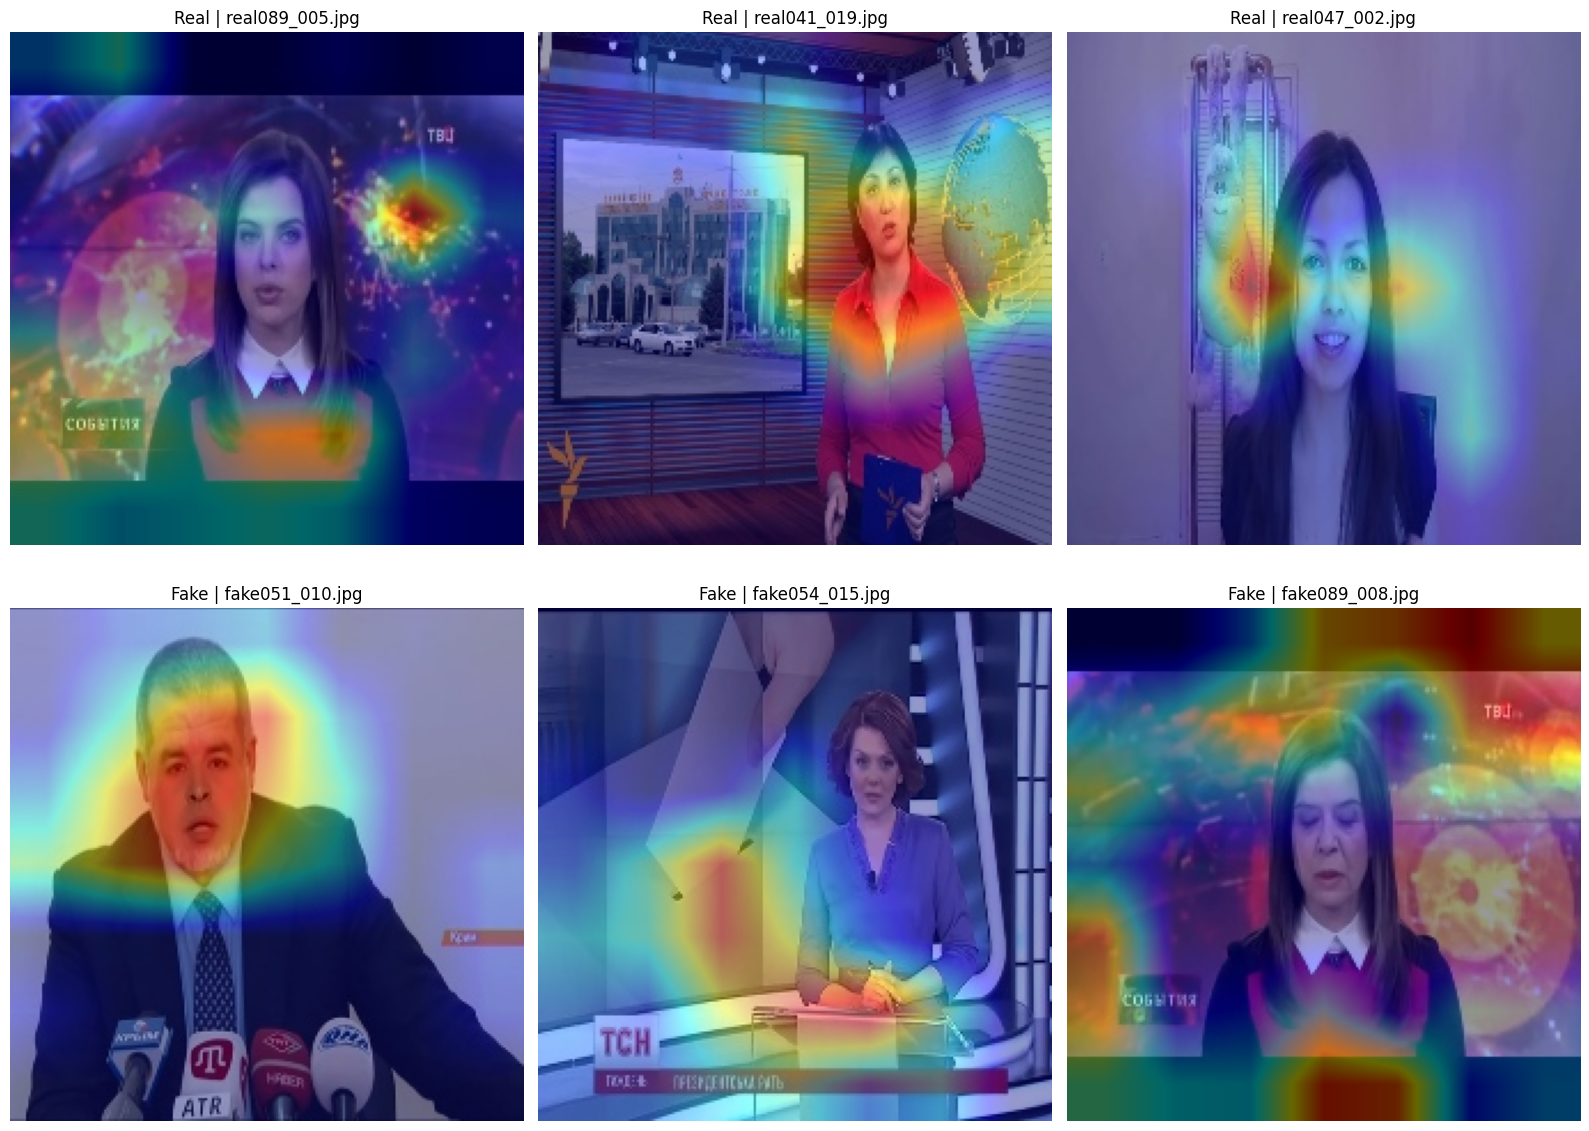

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image


image_paths = [
    "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/real/real089_005.jpg",
    "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/real/real041_019.jpg",
    "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/real/real047_002.jpg",
    "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/fake/fake051_010.jpg",
    "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/fake/fake054_015.jpg",
    "/content/drive/MyDrive/Capstone2025_DeepfakeDetection/data/frames_split/test/fake/fake089_008.jpg"
]

# load and preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = x / 255.0  # normalize to [0, 1]
    x = np.expand_dims(x, axis=0)
    return x, np.array(img)

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="out_relu"):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# overlay heatmap
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

# visualize all selected smages
plt.figure(figsize=(16, 12))
for idx, path in enumerate(image_paths):
    preprocessed, original = preprocess_image(path)
    heatmap = make_gradcam_heatmap(preprocessed, model)

    gradcam_img = display_gradcam(path, heatmap)

    plt.subplot(2, 3, idx +1)
    plt.imshow(gradcam_img)
    plt.axis("off")
    label = "Real" if "real" in path else "Fake"
    plt.title(f"{label} | {path.split('/')[-1]}")
plt.tight_layout()
plt.show()
